# Time Series Logistic Regression Algorithm

This algorithm is used to forecast FOREX prices for the EURUSD pair. It fetches data from MetaTrader5 and applies feature engineering to create additional data.

The forecasted values are set to:
- **Position 1** if the prediction indicates that the price will go up in the next hour
- **Position 0** if the prediction indicates that the price will go down in the nex hourx hour

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
from matplotlib import cycler
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import MetaTrader5 as mt5
from datetime import datetime
from UsefulFunctions import data, backtest
import ta

In [68]:
# Initiate bound between MetaTrader5 and Python
mt5.initialize()

True

In [200]:
# Fetching data from MetaTrader5 from 2015 to the present using the custom function "get_rates" from the data.py file
# The historical data retrieved is of 1-hour timeframe
df = data.get_rates("EURUSD", mt5.TIMEFRAME_H1, datetime(2015,1,1))
df.head()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2015-01-02 08:00:00,1.2051,1.2057,1.2048,1.2054,134,20,0
2015-01-02 09:00:00,1.2053,1.2058,1.2034,1.2055,650,20,0
2015-01-02 10:00:00,1.2056,1.2069,1.2044,1.2047,871,20,0
2015-01-02 11:00:00,1.2048,1.2060,1.2038,1.2057,875,20,0
2015-01-02 12:00:00,1.2056,1.2056,1.2042,1.2050,441,20,0


In [202]:
# Drop "spread" and "real_volume" columns and remane columns "tick_volumne" to only "volumne"
df = df[["open", "high", "low", "close", "tick_volume"]]
df.rename(columns={'tick_volume': 'volume'}, inplace=True)
df.head()

,open,high,low,close,volume
time,,,,,
2015-01-02 08:00:00,1.2051,1.2057,1.2048,1.2054,134
2015-01-02 09:00:00,1.2053,1.2058,1.2034,1.2055,650
2015-01-02 10:00:00,1.2056,1.2069,1.2044,1.2047,871
2015-01-02 11:00:00,1.2048,1.2060,1.2038,1.2057,875
2015-01-02 12:00:00,1.2056,1.2056,1.2042,1.2050,441


## Feature Engineering 
**Creating new input variables from raw data**

In [205]:
# Create a second DataFrame from the close column and compute the percent change in a new column
df_copy = df[["close"]]
df_copy["pct_change"] = df_copy["close"].pct_change(1)
df_copy

,close,pct_change
time,,
2015-01-02 08:00:00,1.20540,NaN
2015-01-02 09:00:00,1.20550,0.000083
2015-01-02 10:00:00,1.20470,-0.000664
2015-01-02 11:00:00,1.20570,0.000830
2015-01-02 12:00:00,1.20500,-0.000581
...,...,...
2024-08-21 00:00:00,1.11281,-0.000045
2024-08-21 01:00:00,1.11279,-0.000018
2024-08-21 02:00:00,1.11271,-0.000072


In [207]:
# New DataFrame with all indications from "ta" library and shifting them by one row
df_indicators = ta.add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume", fillna=True).shift(1)
df_indicators

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02 09:00:00,1.20510,1.20570,1.20480,1.20540,134.0,44.666667,1.340000e+02,0.333333,0.000000,0.000000,0.000000,0.000000,1.205300,50.000000,1000.000000,1.205400,1.205400,1.205400,0.000000,0.000000,0.0,0.0,1.205300,1.206200,1.204400,0.149340,0.555556,0.0,0.0,1.20480,1.20570,1.205250,0.074664,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,1.205400,1.205400,1.205400,1.205400,0.000000,0.000000,0.000000,7.603742,1.000000,-0.085212,76.069593,76.069593,0.000000,1.205250,1.205250,1.205250,1.205250,0.000000,0.000000,0.000000,0.000000,0.000000,1.120228,1.120315,0.0,0.0,0.0,1.204400,1.205700,0.0,0.0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.666667,66.666667,-33.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.205400,0.000000,0.000000,0.000000
2015-01-02 10:00:00,1.20530,1.20580,1.20340,1.20550,650.0,532.166667,7.840000e+02,0.678784,0.065000,-0.240000,-0.240000,0.053924,1.204968,0.000000,1000.000000,1.205450,1.205550,1.205350,0.016591,0.750000,0.0,0.0,1.205100,1.206750,1.203450,0.273836,0.621212,0.0,0.0,1.20340,1.20580,1.204600,0.199096,0.875000,0.000000,0.000000,0.000008,0.000002,0.000006,1.205450,1.205450,1.205415,1.205407,0.011375,0.026162,-0.014787,0.000016,2.250000,-0.085262,76.114229,76.091911,0.022318,1.204600,1.204600,1.204600,1.204600,0.000000,0.000000,0.000000,0.000000,-66.666667,1.120228,1.120315,4.0,4.0,0.0,1.204400,1.205700,0.0,0.0,100.000000,0.000000,0.000000,0.000000,100.000000,63.636364,87.500000,77.083333,-12.500000,0.000000,0.000000,0.000662,0.000132,0.000529,23.900744,4.780149,19.120596,1.205445,0.008296,0.008296,0.008296
2015-01-02 11:00:00,1.20560,1.20690,1.20440,1.20470,871.0,-129.793333,1.844674e+19,-0.078425,-0.043829,0.301378,0.030689,-0.524093,1.205160,57.273757,1000.000000,1.205200,1.205912,1.204488,0.118122,0.148780,0.0,0.0,1.205178,1.207111,1.203244,0.320838,0.376437,0.0,0.0,1.20340,1.20690,1.205150,0.290408,0.371429,0.000000,0.000000,-0.000050,-0.000009,-0.000041,1.205200,1.205200,1.205305,1.205355,0.049772,0.040924,0.008848,-0.000087,3.627358,-0.085012,75.891052,76.024958,-0.133906,1.205150,1.205150,1.205150,1.205150,0.000000,0.000000,0.000000,0.000000,56.000000,1.120228,

In [208]:
# Identifying columns with all zero values to avoid interference during model training
zero_columns_list = df_indicators.columns[(df_indicators == 0).all(axis=0)].tolist()
zero_columns_list

[]

In [209]:
# Concatenating both dataframes and drop the close column (which wasn't shifted) from df_copy
new_df = pd.concat((df_indicators, df_copy["pct_change"]), axis=1)
new_df.dropna(inplace=True)

# Making sure all columns are shown
pd.set_option('display.max_columns', None)

new_df.head()

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,pct_change
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 09:00:00,1.2051,1.2057,1.2048,1.2054,134.0,44.666667,1.340000e+02,0.333333,0.000000,0.000000,0.000000,0.000000,1.205300,50.000000,1000.000000,1.205400,1.205400,1.205400,0.000000,0.000000,0.0,0.0,1.205300,1.206200,1.204400,0.149340,0.555556,0.0,0.0,1.2048,1.2057,1.20525,0.074664,0.666667,0.0,0.0,0.000000,0.000000,0.000000,1.205400,1.205400,1.205400,1.205400,0.000000,0.000000,0.000000,7.603742,1.000000,-0.085212,76.069593,76.069593,0.000000,1.20525,1.20525,1.20525,1.20525,0.0,0.0,0.0,0.0,0.000000,1.120228,1.120315,0.0,0.0,0.0,1.2044,1.2057,0.0,0.0,100.000000,0.0,0.0,0.0,0.000000,0.000000,66.666667,66.666667,-33.333333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.205400,0.000000,0.000000,0.000000,0.000083
2015-01-02 10:00:00,1.2053,1.2058,1.2034,1.2055,650.0,532.166667,7.840000e+02,0.678784,0.065000,-0.240000,-0.240000,0.053924,1.204968,0.000000,1000.000000,1.205450,1.205550,1.205350,0.016591,0.750000,0.0,0.0,1.205100,1.206750,1.203450,0.273836,0.621212,0.0,0.0,1.2034,1.2058,1.20460,0.199096,0.875000,0.0,0.0,0.000008,0.000002,0.000006,1.205450,1.205450,1.205415,1.205407,0.011375,0.026162,-0.014787,0.000016,2.250000,-0.085262,76.114229,76.091911,0.022318,1.20460,1.20460,1.20460,1.20460,0.0,0.0,0.0,0.0,-66.666667,1.120228,1.120315,4.0,4.0,0.0,1.2044,1.2057,0.0,0.0,100.000000,0.0,0.0,0.0,100.000000,63.636364,87.500000,77.083333,-12.500000,0.0,0.0,0.000662,0.000132,0.000529,23.900744,4.780149,19.120596,1.205445,0.008296,0.008296,0.008296,-0.000664
2015-01-02 11:00:00,1.2056,1.2069,1.2044,1.2047,871.0,-129.793333,1.844674e+19,-0.078425,-0.043829,0.301378,0.030689,-0.524093,1.205160,57.273757,1000.000000,1.205200,1.205912,1.204488,0.118122,0.148780,0.0,0.0,1.205178,1.207111,1.203244,0.320838,0.376437,0.0,0.0,1.2034,1.2069,1.20515,0.290408,0.371429,0.0,0.0,-0.000050,-0.000009,-0.000041,1.205200,1.205200,1.205305,1.205355,0.049772,0.040924,0.008848,-0.000087,3.627358,-0.085012,75.891052,76.024958,-0.133906,1.20515,1.20515,1.20515,1.20515,0.0,0.0,0.0,0.0,56.000000,1.120228,1.120315,8.0,4.0,4.0,1.2044,1.2057,0.0,1.0,10.400000,0.0,0.0,0.0,83.673469,41.379310,37.142857,63.769841,-62.857143,0.0,0.0,-0.004122,-0.000718,-0.003403,40.437201,11.911559,28.525642,1.205121,-0.066363,-0.066385,-0.058072,0.000830
2015-01-02 12:00:00,1.2048,1.2060,1.2038,1.2057,875.0,506.570303,7.880000e+02,0.200225,0.087433,-0.188571,-0.042398,0.202228,1.205163,36.357636,1000.000000,1.205325,1.206078,1.204572,0.125000,0.748896,0.0,0.0,1.205175,1.207175,1.203175,0.331902,0.631250,0.0,0.0,1.2034,1.2069,1.20515,0.290378,0.657143,

## Implementing Machine Learning

In [211]:
# Splitting the data into features and labels for the ML model using the custom function "split_data" from data.py file
X = new_df.iloc[:,:-1]
y = new_df["pct_change"]

X_train, y_train, X_test, y_test = data.split_data(X, y)

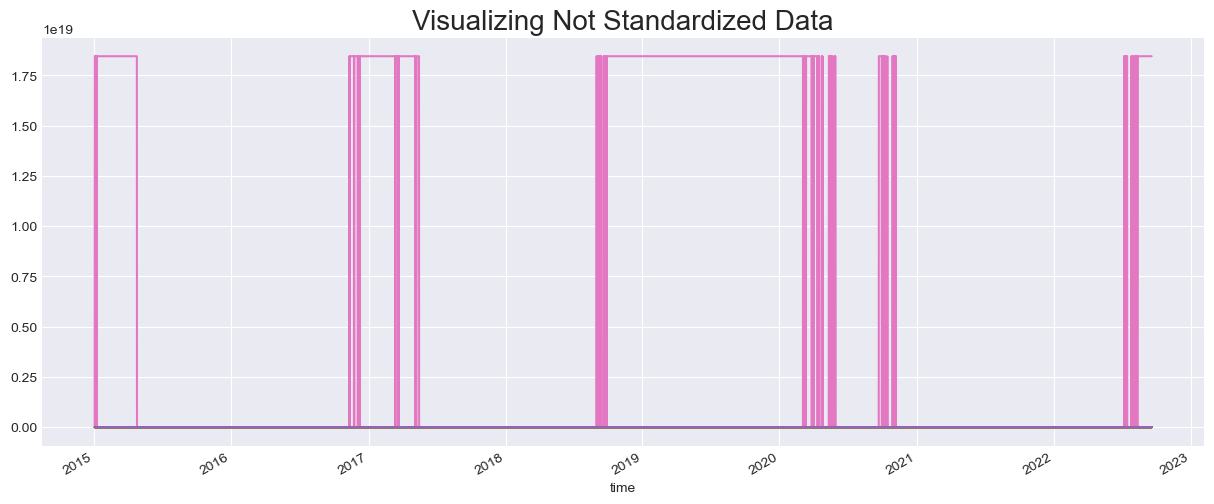

In [239]:
# Plotting features before standardization to visualize their unequal scales (plot shows only the first 15 indicators)
X_train.iloc[:,:15].plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Visualizing Not Standardized Data", fontsize=20)
plt.show()

### Applying StandardScaler to Normalize Features

In [214]:
from sklearn.preprocessing import StandardScaler

In [215]:
# Only the feature sets (X) need to be standardized, not the targets (y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

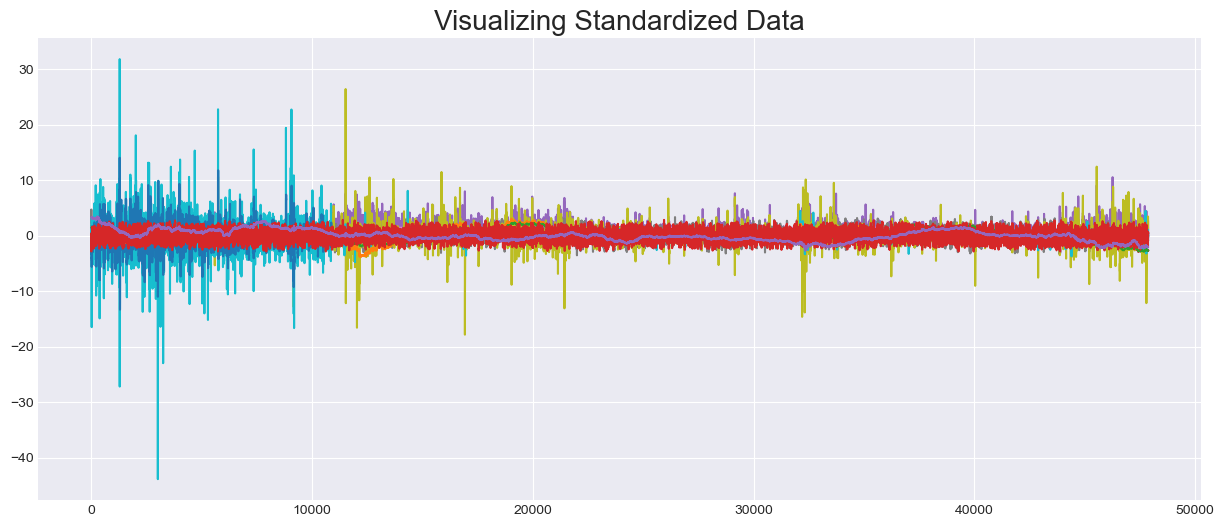

In [216]:
pd.DataFrame(X_train_scaled).iloc[:,:15].plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Visualizing Standardized Data", fontsize=20);

### Training the Logistic Regression Model

In [218]:
from sklearn.linear_model import LogisticRegression

In [219]:
regresor = LogisticRegression()

classifier = LogisticRegression()

# Training the Model Using np.sign() to convert continuous labels to binary (1 or -1), 
# as Logistic Regression expects discrete class labels.
classifier.fit(X_train_scaled, np.sign(y_train))

# Making predictions
predictions = classifier.predict(X_test_scaled)

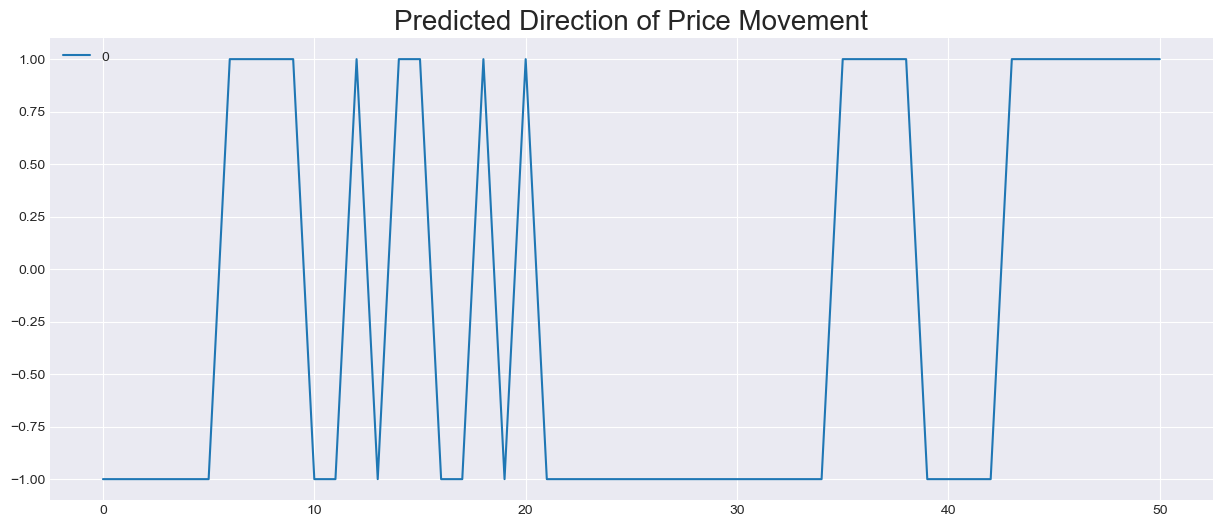

In [220]:
# Plotting the predictions to visualize if they are correctly predicting both directions (1 or -1)
# Limiting the plot to the first 50 rows for a clearer visualization of the model's directional predictions
pd.DataFrame(predictions).loc[:50].plot(figsize=(15, 6))
plt.title("Predicted Direction of Price Movement", fontsize=20);

**Compute Returns for Logistic Regression Model**

In [222]:
# Check the docstring of the "compute_strategy_returns" function from the backtest.py file
returns = backtest.compute_strategy_returns(y_test, predictions)
returns

,pct_change,prediction,real_position,pred_position,returns
time,,,,,
2022-09-19 01:00:00,0.000779,-1.0,1.0,-1.0,-0.000779
2022-09-19 02:00:00,0.000170,-1.0,1.0,-1.0,-0.000170
2022-09-19 03:00:00,-0.001108,-1.0,-1.0,-1.0,0.001108
2022-09-19 04:00:00,-0.000290,-1.0,-1.0,-1.0,0.000290
2022-09-19 05:00:00,-0.000530,-1.0,-1.0,-1.0,0.000530
...,...,...,...,...,...
2024-08-21 00:00:00,-0.000045,-1.0,-1.0,-1.0,0.000045
2024-08-21 01:00:00,-0.000018,-1.0,-1.0,-1.0,0.000018
2024-08-21 02:00:00,-0.000072,-1.0,-1.0,-1.0,0.000072


**Plot returns from Logistic Regression Model Predictions**

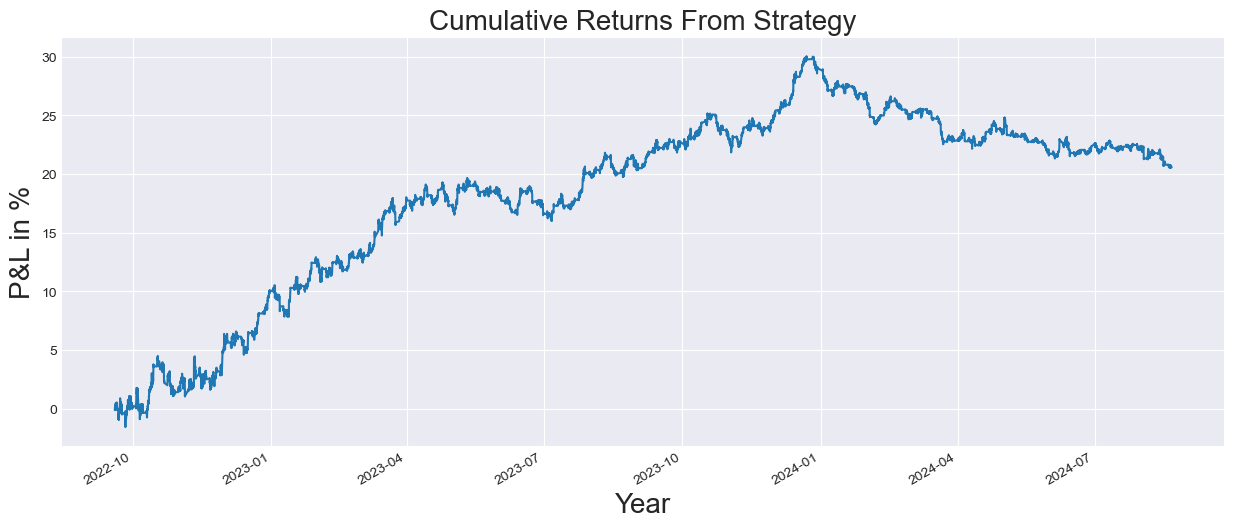

In [224]:
# Check the docstring of the "plot_returns" function from the backtest.py file
backtest.plot_returns(returns["returns"])

**Logistic Regression Model Accuracy Analysis**

Counts of 0 indicate instances where the predicted position did not match the real position.
Counts of 1 indicate instances where the predicted position matched the real position.

accuracy
1    6099
0    5869
Name: count, dtype: int64

Model has an accuracy of: 50.96%


,real_position,pred_position,accuracy
time,,,
2022-09-19 01:00:00,1.0,-1.0,0
2022-09-19 02:00:00,1.0,-1.0,0
2022-09-19 03:00:00,-1.0,-1.0,1
2022-09-19 04:00:00,-1.0,-1.0,1
2022-09-19 05:00:00,-1.0,-1.0,1
...,...,...,...
2024-08-21 00:00:00,-1.0,-1.0,1
2024-08-21 01:00:00,-1.0,-1.0,1
2024-08-21 02:00:00,-1.0,-1.0,1


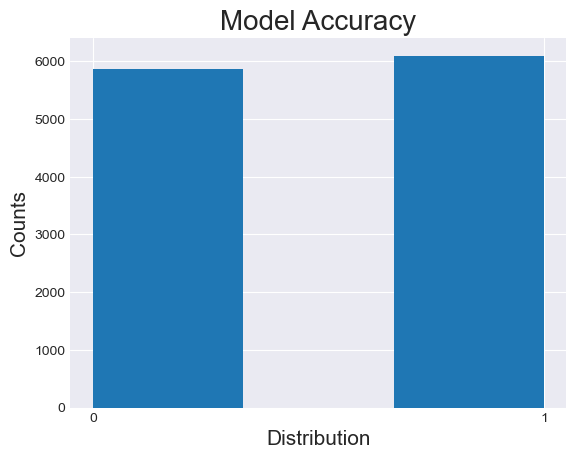

In [242]:
# Check the docstring of the "compute_model_accuracy" function from the backtest.py file
backtest.compute_model_accuracy(returns["real_position"], returns["pred_position"])

**Computing Key Performance Ratios**

In [245]:
# Check the docstring of the "vectorize_backtest_returns" function from the backtest.py file
backtest.vectorize_backtest_returns(returns["returns"], 24)

Sortino Ratio: 1.687
- Positive Sortino (> 0): The investment’s returns exceed the target return after accounting for downside risk.

***Asset for Benchamark is S&P500***

Beta Ratio: -0.002
- Beta < 1: The asset is less volatile than the market (considered less risky).

Alpha Ratio: 10.417
- Positive Alpha (> 0): The investment outperformed the market.


**Strategy Model Drawdown**

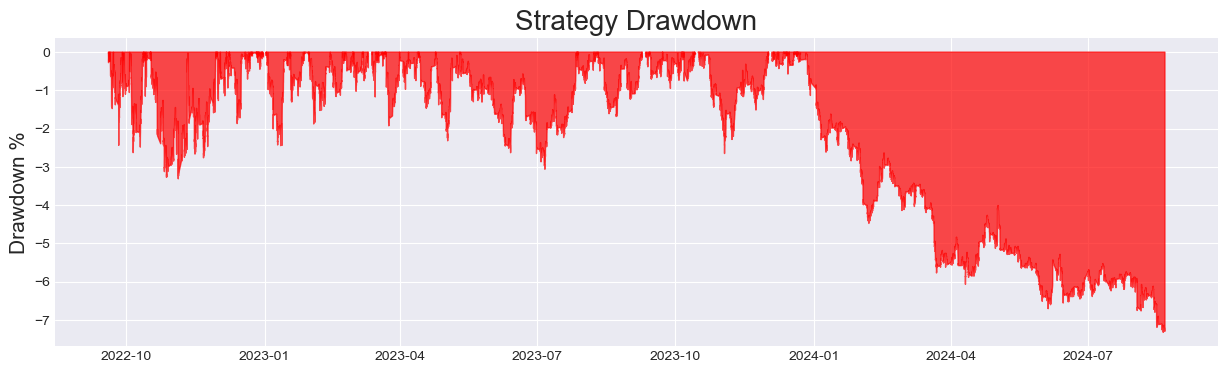

Max Drawdown: -7.32%


In [248]:
# Check the docstring of the "strategy_drawdown" function from the backtest.py file
backtest.strategy_drawdown(returns["returns"])

## Note: 
**The initial analysis of the Logistic Regression model for the forex pair shows promising results at the beginning of the test period. However, further analysis is needed to refine the strategy. It is recommended to explore alternative models, adjust parameters, and revisit the feature set to optimize performance and minimize potential drawdowns.**
